In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27 # figure size in inches

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 500) 
pd.set_option('display.max_columns', 30) 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

%config Completer.use_jedi = False

import joblib

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import *

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import VotingClassifier


from IPython.display import display

In [2]:
df_agg_cat = pd.read_csv('CSV/df_agg_cat.csv')
df_agg_cat_drug = pd.read_csv('CSV/df_agg_cat_drug.csv')

# Build models
## Generate result and store in dict
* Set weight to prevent bias, 4 to CKD (1), 1 to non-CKD (0)
* Implement GridSearchCV to find the best parameters

In [3]:
def train_model(model, parameters, algoname, X_train, X_test, y_train, preds, months_name):

    print('========================================')
    print('Training %s ' % algoname)
    print()
    
    scores = ['f1']
    
    # retain for loop in case want to try different scores
    for score in scores:

        print("# Tuning hyper-parameters for %s" % score)
        print()

        pipe = Pipeline(steps=[('model', model)])

        search = GridSearchCV(pipe, parameters, n_jobs=-1)
        search.fit(X_train, y_train)
        
        print("Best parameter (CV score=%0.3f):" % search.best_score_)
        print()
        print("Best parameters set found on development set:")
        print()
        print(search.best_params_)
        print()
        print("Grid scores on development set:")
        print()
        means = search.cv_results_['mean_test_score']
        stds = search.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, search.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))
       
        # Obtained best model
        optimized_model = search.best_estimator_
        
        # Save model
        if 'drug' in months_name:
            months_name = months_name.split('_')[0]
            joblib.dump(optimized_model, 'models/' + months_name + '/'+ algoname +'_cat_drug.joblib')
        else:
            joblib.dump(optimized_model, 'models/' + months_name + '/'+ algoname +'_cat.joblib')
        
        
        # Get predictions
        y_pred = optimized_model.predict(X_test)
        y_pred_proba = optimized_model.predict_proba(X_test)[:,1] # only get probability for 1
        
        preds[algoname] = {
        'pred': y_pred,
        'pred_proba': y_pred_proba
    }        
        
        return preds

In [4]:
# For ensemble
def get_predictions(model, preds, X_test, algoname):

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1] # only get probability for 1

    preds[algoname] = {
    'pred': y_pred,
    'pred_proba': y_pred_proba
    }
    
    return preds

In [5]:
# Logistic regression
model_lr = LogisticRegression(random_state=0, max_iter=10000, class_weight={0: 1, 1: 4})
parameters_lr = {'model__C': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 10, 100,1000, 1e4, 1e5, 1e6]}

# Decision tree
model_dt = DecisionTreeClassifier(random_state=0, class_weight={0: 1, 1: 4}, min_samples_leaf = 30)    
parameters_dt = {'model__max_depth': np.linspace(10, 100, 10)}

# lightGBM
model_lgbm = LGBMClassifier(n_estimators=1000, objective='binary',scale_pos_weight=4)
parameters_lgbm = {'model__learning_rate': [1e-05, 1e-04, 1e-03, 1e-02, 1e-01, 1, 10, 100]}

# Random forest
model_rf = RandomForestClassifier(class_weight={0: 1, 1: 4}, n_estimators=800, n_jobs=-1, verbose=1)
parameters_rf = {'model__max_depth': list(range(1,31))}

In [6]:
X = df_agg_cat[['sbp', 'dbp', 'creatinine', 'glucose', 'ldl', 'hgb',
       'atenolol', 'atorvastatin', 'bisoprolol', 'canagliflozin', 'carvedilol',
       'dapagliflozin', 'irbesartan', 'labetalol', 'losartan', 'lovastatin',
       'metformin', 'metoprolol', 'nebivolol', 'olmesartan', 'pitavastatin',
       'pravastatin', 'propranolol', 'rosuvastatin', 'simvastatin',
       'telmisartan', 'valsartan', 'race', 'gender', 'age']]

y = df_agg_cat['Stage_Progress']

# Split train-test data
from sklearn.model_selection import train_test_split

X_train_agg, X_test_agg, y_train_agg, y_test_agg = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

preds_agg = {'y': y_test_agg}

preds_agg = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_agg, X_test_agg, y_train_agg, preds_agg, 'agg')
preds_agg = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_agg, X_test_agg, y_train_agg, preds_agg, 'agg')
preds_agg = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_agg, X_test_agg, y_train_agg, preds_agg, 'agg')
preds_agg = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_agg, X_test_agg, y_train_agg, preds_agg, 'agg')

joblib.dump(preds_agg, 'predictions/predictions_agg_cat.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.525):

Best parameters set found on development set:

{'model__C': 10}

Grid scores on development set:

0.333 (+/-0.000) for {'model__C': 1e-05}
0.333 (+/-0.000) for {'model__C': 0.0001}
0.333 (+/-0.000) for {'model__C': 0.001}
0.333 (+/-0.000) for {'model__C': 0.01}
0.438 (+/-0.059) for {'model__C': 0.1}
0.513 (+/-0.082) for {'model__C': 1}
0.525 (+/-0.096) for {'model__C': 10}
0.517 (+/-0.138) for {'model__C': 100}
0.512 (+/-0.128) for {'model__C': 1000}
0.512 (+/-0.128) for {'model__C': 10000.0}
0.512 (+/-0.128) for {'model__C': 100000.0}
0.512 (+/-0.128) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.412):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.412 (+/-0.122) for {'model__max_depth': 10.0}
0.412 (+/-0.122) for {'model__max_depth': 20.0}
0.412 (+/

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.7s finished


Best parameter (CV score=0.675):

Best parameters set found on development set:

{'model__max_depth': 23}

Grid scores on development set:

0.333 (+/-0.000) for {'model__max_depth': 1}
0.329 (+/-0.017) for {'model__max_depth': 2}
0.367 (+/-0.082) for {'model__max_depth': 3}
0.400 (+/-0.148) for {'model__max_depth': 4}
0.450 (+/-0.122) for {'model__max_depth': 5}
0.492 (+/-0.107) for {'model__max_depth': 6}
0.537 (+/-0.135) for {'model__max_depth': 7}
0.562 (+/-0.105) for {'model__max_depth': 8}
0.583 (+/-0.115) for {'model__max_depth': 9}
0.592 (+/-0.094) for {'model__max_depth': 10}
0.604 (+/-0.070) for {'model__max_depth': 11}
0.629 (+/-0.100) for {'model__max_depth': 12}
0.650 (+/-0.076) for {'model__max_depth': 13}
0.667 (+/-0.070) for {'model__max_depth': 14}
0.667 (+/-0.070) for {'model__max_depth': 15}
0.662 (+/-0.061) for {'model__max_depth': 16}
0.671 (+/-0.067) for {'model__max_depth': 17}
0.671 (+/-0.081) for {'model__max_depth': 18}
0.662 (+/-0.061) for {'model__max_depth':

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_agg_cat.joblib']

In [7]:
def get_predictions(model, X_test, algoname):

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:,1] # only get probability for 1

    preds_agg_ensemble[algoname] = {
    'pred': y_pred,
    'pred_proba': y_pred_proba
    }
    
    return preds_agg_ensemble

In [8]:
folder_name = 'agg'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression_cat.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier_cat.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier_cat.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier_cat.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_agg, y_train_agg)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_agg, y_train_agg)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_agg, y_train_agg)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_agg, y_train_agg)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

In [9]:
# Get predictions
preds_agg_ensemble = {'y': y_test_agg}
preds_agg_ensemble = get_predictions(eclf, X_test_agg, 'VotingClassifier')
preds_agg_ensemble = get_predictions(model_stack1, X_test_agg, 'StackingClassifier_logistic')
preds_agg_ensemble = get_predictions(model_stack2, X_test_agg, 'StackingClassifier_rf')
preds_agg_ensemble = get_predictions(model_stack3, X_test_agg, 'StackingClassifier_lgbm')

joblib.dump(preds_agg_ensemble, 'predictions/preds_agg_ensemble_cat.joblib')

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(

['predictions/preds_agg_ensemble_cat.joblib']

In [10]:
X = df_agg_cat_drug[['id', 'sbp', 'dbp', 'creatinine', 'glucose', 'ldl', 'hgb',
       'race', 'gender', 'age', 'glucose_treatment',
       'bp_treatment', 'cholesterol_treatment']]

y = df_agg_cat_drug['Stage_Progress']

# Split train-test data
from sklearn.model_selection import train_test_split

X_train_agg_drug, X_test_agg_drug, y_train_agg_drug, y_test_agg_drug = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=0)

preds_agg_drug = {'y': y_test_agg_drug}

preds_agg_drug = train_model(model_lr, parameters_lr, 'LogisticRegression', X_train_agg_drug, X_test_agg_drug, y_train_agg_drug, preds_agg_drug, 'agg_drug')
preds_agg_drug = train_model(model_dt, parameters_dt, 'DecisionTreeClassifier', X_train_agg_drug, X_test_agg_drug, y_train_agg_drug, preds_agg_drug, 'agg_drug')
preds_agg_drug = train_model(model_lgbm, parameters_lgbm, 'LGBMClassifier', X_train_agg_drug, X_test_agg_drug, y_train_agg_drug, preds_agg_drug, 'agg_drug')
preds_agg_drug = train_model(model_rf, parameters_rf, 'RandomForestClassifier', X_train_agg_drug, X_test_agg_drug, y_train_agg_drug, preds_agg_drug, 'agg_drug')

joblib.dump(preds_agg_drug, 'predictions/predictions_agg_cat_drug.joblib')

Training LogisticRegression 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.454):

Best parameters set found on development set:

{'model__C': 1}

Grid scores on development set:

0.333 (+/-0.000) for {'model__C': 1e-05}
0.333 (+/-0.000) for {'model__C': 0.0001}
0.333 (+/-0.000) for {'model__C': 0.001}
0.337 (+/-0.017) for {'model__C': 0.01}
0.433 (+/-0.067) for {'model__C': 0.1}
0.454 (+/-0.072) for {'model__C': 1}
0.450 (+/-0.042) for {'model__C': 10}
0.446 (+/-0.033) for {'model__C': 100}
0.446 (+/-0.033) for {'model__C': 1000}
0.446 (+/-0.033) for {'model__C': 10000.0}
0.446 (+/-0.033) for {'model__C': 100000.0}
0.442 (+/-0.049) for {'model__C': 1000000.0}
Training DecisionTreeClassifier 

# Tuning hyper-parameters for f1

Best parameter (CV score=0.438):

Best parameters set found on development set:

{'model__max_depth': 10.0}

Grid scores on development set:

0.438 (+/-0.139) for {'model__max_depth': 10.0}
0.438 (+/-0.139) for {'model__max_depth': 20.0}
0.438 (+/-

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.6s finished


Best parameter (CV score=0.679):

Best parameters set found on development set:

{'model__max_depth': 20}

Grid scores on development set:

0.333 (+/-0.000) for {'model__max_depth': 1}
0.342 (+/-0.020) for {'model__max_depth': 2}
0.408 (+/-0.068) for {'model__max_depth': 3}
0.479 (+/-0.095) for {'model__max_depth': 4}
0.512 (+/-0.125) for {'model__max_depth': 5}
0.554 (+/-0.141) for {'model__max_depth': 6}
0.575 (+/-0.150) for {'model__max_depth': 7}
0.592 (+/-0.111) for {'model__max_depth': 8}
0.621 (+/-0.061) for {'model__max_depth': 9}
0.633 (+/-0.033) for {'model__max_depth': 10}
0.667 (+/-0.026) for {'model__max_depth': 11}
0.662 (+/-0.031) for {'model__max_depth': 12}
0.658 (+/-0.062) for {'model__max_depth': 13}
0.671 (+/-0.067) for {'model__max_depth': 14}
0.662 (+/-0.081) for {'model__max_depth': 15}
0.679 (+/-0.033) for {'model__max_depth': 16}
0.667 (+/-0.059) for {'model__max_depth': 17}
0.662 (+/-0.072) for {'model__max_depth': 18}
0.675 (+/-0.062) for {'model__max_depth':

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elapsed:    0.0s finished


['predictions/predictions_agg_cat_drug.joblib']

In [11]:
folder_name = 'agg'
    
# Load models
clf1 = joblib.load('models/'+ folder_name +'/LogisticRegression_cat_drug.joblib')
clf2 = joblib.load('models/'+ folder_name +'/RandomForestClassifier_cat_drug.joblib')
clf3 = joblib.load('models/'+ folder_name +'/DecisionTreeClassifier_cat_drug.joblib')
clf4 = joblib.load('models/'+ folder_name +'/LGBMClassifier_cat_drug.joblib')

# Build ensemble
eclf = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], voting='soft').fit(X_train_agg_drug, y_train_agg_drug)

# Stacked
model_stack1 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LogisticRegression(), cv=5).fit(X_train_agg_drug, y_train_agg_drug)
model_stack2 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=RandomForestClassifier(), cv=5).fit(X_train_agg_drug, y_train_agg_drug)
model_stack3 = StackingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3), ('lgbm', clf4)], final_estimator=LGBMClassifier(), cv=5).fit(X_train_agg_drug, y_train_agg_drug)

# Get predictions
preds_agg_ensemble = {'y': y_test_agg_drug}
preds_agg_ensemble = get_predictions(eclf, X_test_agg_drug, 'VotingClassifier')
preds_agg_ensemble = get_predictions(model_stack1, X_test_agg_drug, 'StackingClassifier_logistic')
preds_agg_ensemble = get_predictions(model_stack2, X_test_agg_drug, 'StackingClassifier_rf')
preds_agg_ensemble = get_predictions(model_stack3, X_test_agg_drug, 'StackingClassifier_lgbm')

joblib.dump(preds_agg_ensemble, 'predictions/preds_agg_ensemble_cat_drug.joblib')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 800 out of 800 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 800 out of 800 | elaps

['predictions/preds_agg_ensemble_cat_drug.joblib']

# Compare models

In [12]:
def specificity(y_valid, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    
    specificity = tn / (tn+fp)
    return specificity

# Performance of a dichotomous diagnostic test
def youden_index(y, pred_proba):
    fpr, tpr, thresh = roc_curve(y, pred_proba)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresh[optimal_idx]
    return optimal_threshold

# Threshold used
def get_threshold_table(preds):
    thresh = [[algo, val['threshold']] for algo, val in preds.items() if algo != 'y']
    return pd.DataFrame(thresh, columns=['Algo', "Threshold"])

In [13]:
def compute_matrics(predications, days_bin):
    # Calculate probability thresholds
    for algo, preds in predications.items():
        if algo == 'y':
            continue
        threshold = youden_index(predications['y'], preds['pred_proba'])
        preds['threshold'] = threshold
        preds['pred'] = preds['pred_proba'] >= threshold

    # Get threshold to categorize as 1 (CKD)
    threshold = pd.concat([get_threshold_table(preds) for preds in [predications]])
    pd.set_option('display.float_format', lambda x: '%.5f' % x)
    display(threshold)

    # Compute matrics
    metrics_list = []

    y_truth = predications['y']
    for algo, preds in predications.items():
        if algo == 'y':
            continue

        y_pred = preds['pred']
        y_pred_proba = preds['pred_proba']

        acc = accuracy_score(y_truth, y_pred)
        f1 = f1_score(y_truth, y_pred)
        prec = precision_score(y_truth, y_pred)
        rec = recall_score(y_truth, y_pred)
        spec = specificity(y_truth, y_pred)
        roc = roc_auc_score(y_truth, y_pred_proba)

        row = [algo, acc, f1, prec, rec, spec, roc]
        metrics_list.append(row)

    cols = ['Algorithm', 'Accuracy', 'F1', 'Precision', 'Recall', 'Specificiy', 'ROC_AUC']
    metrics = pd.DataFrame(metrics_list, columns=cols)
    display(metrics.sort_values('ROC_AUC'))


    # Plot ROC
    fig = plt.figure(figsize=(6,6))
    lw = 2

    rocs = []
    for algo, model in predications.items():
        if algo == 'y':
            continue
        fpr, tpr, thresh = roc_curve(predications['y'], predications[algo]['pred_proba'])
        auc = roc_auc_score(predications['y'], predications[algo]['pred_proba'])
        auc = round(auc, 3)
        rocs.append((algo, auc, [fpr, tpr]))
    # sort legend by AUC
    rocs = sorted(rocs, key=lambda x: x[1], reverse=True)
    for algo, auc, [fpr, tpr] in rocs:    
        plt.plot(fpr,tpr, label=algo+f' ({auc})', lw=lw)

    # chance line
    plt.plot([0, 1], [0, 1], color='navy', label='chance line (0.5)', linestyle='--', lw=lw)
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    # plt.title('ROC curve for 6 months', size=12)
    plt.text(0.7,0.3, days_bin, fontsize=12)
    plt.grid(linewidth=1.2, color='lightgray')
    plt.legend(loc='lower right')
    plt.savefig('figures/' + days_bin + '_agg_cat.jpg')

,Algo,Threshold
0,LogisticRegression,0.79004
1,DecisionTreeClassifier,0.88000
2,LGBMClassifier,0.33840
3,RandomForestClassifier,0.42375


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
3,RandomForestClassifier,0.66667,0.37500,0.50000,0.30000,0.85000,0.53062
1,DecisionTreeClassifier,0.70000,0.35714,0.62500,0.25000,0.92500,0.53875
2,LGBMClassifier,0.66667,0.33333,0.50000,0.25000,0.87500,0.56500
0,LogisticRegression,0.68333,0.53659,0.52381,0.55000,0.75000,0.60625


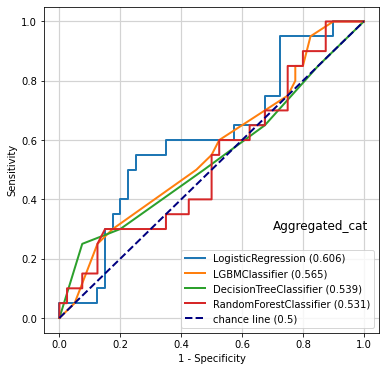

In [14]:
compute_matrics(joblib.load('predictions/predictions_agg_cat.joblib'), 'Aggregated_cat')

,Algo,Threshold
0,VotingClassifier,0.49612
1,StackingClassifier_logistic,0.38942
2,StackingClassifier_rf,0.18000
3,StackingClassifier_lgbm,0.21128


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
1,StackingClassifier_logistic,0.66667,0.52381,0.50000,0.55000,0.72500,0.58375
2,StackingClassifier_rf,0.50000,0.54545,0.39130,0.90000,0.30000,0.59000
0,VotingClassifier,0.65000,0.51163,0.47826,0.55000,0.70000,0.59250
3,StackingClassifier_lgbm,0.65000,0.57143,0.48276,0.70000,0.62500,0.61625


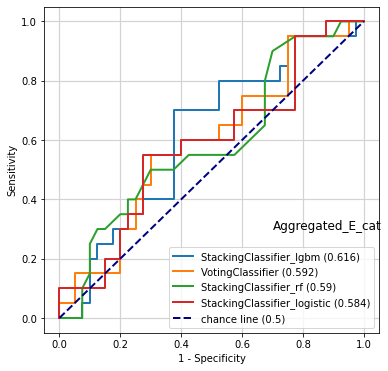

In [15]:
compute_matrics(joblib.load('predictions/preds_agg_ensemble_cat.joblib'), 'Aggregated_E_cat')

,Algo,Threshold
0,LogisticRegression,0.65814
1,DecisionTreeClassifier,0.67368
2,LGBMClassifier,0.33840
3,RandomForestClassifier,0.16375


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
3,RandomForestClassifier,0.45000,0.54795,0.37736,1.00000,0.17500,0.51500
2,LGBMClassifier,0.66667,0.33333,0.50000,0.25000,0.87500,0.52563
0,LogisticRegression,0.56667,0.50000,0.40625,0.65000,0.52500,0.60000
1,DecisionTreeClassifier,0.61667,0.53061,0.44828,0.65000,0.60000,0.64750


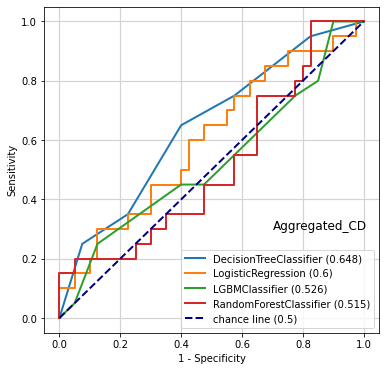

In [16]:
compute_matrics(joblib.load('predictions/predictions_agg_cat_drug.joblib'), 'Aggregated_CD')

,Algo,Threshold
0,VotingClassifier,0.43406
1,StackingClassifier_logistic,0.29490
2,StackingClassifier_rf,0.36000
3,StackingClassifier_lgbm,0.58884


,Algorithm,Accuracy,F1,Precision,Recall,Specificiy,ROC_AUC
1,StackingClassifier_logistic,0.50000,0.54545,0.39130,0.90000,0.30000,0.58875
0,VotingClassifier,0.55000,0.57143,0.41860,0.90000,0.37500,0.59625
3,StackingClassifier_lgbm,0.73333,0.52941,0.64286,0.45000,0.87500,0.68500
2,StackingClassifier_rf,0.70000,0.59091,0.54167,0.65000,0.72500,0.68812


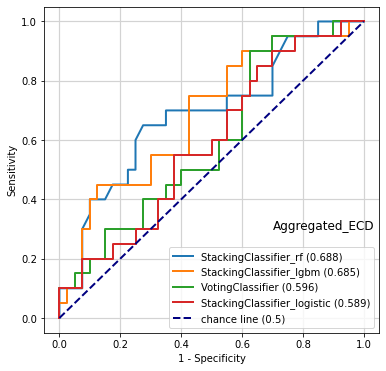

In [17]:
compute_matrics(joblib.load('predictions/preds_agg_ensemble_cat_drug.joblib'), 'Aggregated_ECD')